## Logistic Regression.


#### Built 6 models and trained Logistic Regression/Regularized Logistic Regression each with Batch Gradient Descent, Stochastic Gradient Descent and Mini Batch Gradient Descent. Also, plot their objective values versus epochs and compare their training and testing accuracy and tuned the parameters a little bit to obtain reasonable results.

In [48]:
# Load Packages
import pandas as pd
import numpy 
import decimal as dc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#import warnings
#warnings.filterwarnings('ignore')

# 1. Data processing

- Download the Breast Cancer dataset from https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)
- Load the data.
- Preprocess the data.

## 1.1. Load the data

In [50]:
data = pd.read_csv("/breast-cancer-wisconsin.csv", na_values = "?")
print(data.isna().sum())  #missing values in data
n = data.shape[0]

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


## 1.2 Examine and clean data

In [51]:
# I have dropped id number as it is useless for achieving actual goal 
# I transformed target labels in the second column from 'B' and 'M' to 1 and -1.
for i in range(len(data)):
    if data.diagnosis.values[i] == 'B':
        data.diagnosis.values[i] = 1
    elif data.diagnosis.values[i] == 'M':
        data.diagnosis.values[i] = -1
X = data.iloc[:,2:32]
y = data.iloc[:,1]
X = numpy.concatenate((X, numpy.ones((n,1))), axis = 1)
data1 = data.iloc[:,1:32]
data1 = numpy.concatenate((data1, numpy.ones((n,1))), axis = 1)

## 1.3. Partition to training and testing sets

In [52]:
# I partitioned using 80% training data and 20% testing data. It is a commonly used ratio in machine learning.
x_train, x_test, y_train, y_test = train_test_split(X, y ,test_size=0.20, random_state=104)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(455, 31) (114, 31) (455,) (114,)


## 1.4. Feature scaling

Use the standardization to transform both training and test features

In [53]:
# Standardization


# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))
print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[-0.03918771  0.03224115 -0.034305   -0.04762005  0.05548801  0.04032117
  0.04294226  0.03454617  0.1057932   0.08823995 -0.02361691 -0.07529889
 -0.03524359 -0.04876564  0.08804058 -0.03433828 -0.00767958  0.05448303
 -0.1066496  -0.00529486 -0.01567734  0.0491125  -0.02178224 -0.01692623
  0.12538072 -0.02797654  0.02510498  0.0411214  -0.01728766  0.07675517
  0.        ]
test std = 
[0.9073232  0.96373579 0.90015462 0.85759948 1.02631216 1.04825854
 1.00339182 0.93860019 1.04465493 1.11160245 0.82606559 0.82066776
 0.81033187 0.72510866 0.88613649 0.90586538 0.78215094 0.88572424
 0.87157251 0.83118636 0.93290491 1.06839362 0.91486589 0.94036226
 1.13386132 0.97824412 1.00014728 0.93624929 0.77181074 1.22789735
 0.        ]


# 2.  Logistic Regression Model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

When $\lambda = 0$, the model is a regular logistic regression and when $\lambda > 0$, it essentially becomes a regularized logistic regression.

In [56]:
# Calculated the objective function value, or loss
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     objective function value, or loss (scalar)
def objective(w, x, y, lam):
    n = x.shape[0]
    xy = numpy.multiply(x,y)
    xyw = numpy.dot(xy,w)
    val1 = numpy.array(xyw, dtype= numpy.float128)  #to avoid overflow issue

    exp_term = (1 + numpy.exp(-val1)).astype(float)
    term = numpy.log(exp_term)
    log = 1/n * numpy.sum(term)
    reg = 0.5 * lam * numpy.linalg.norm(w)**2
    obj = log + reg
    return obj

# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ for regularized logistic regression is  $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [60]:
# Calculated the gradient
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     g: gradient: d-by-1 matrix

def gradient(w, x, y, lam):
    n = x.shape[0]
    xy = numpy.multiply(x,y)
    xyw = numpy.dot(xy,w)
    val1 = numpy.array(xyw, dtype= numpy.float128)
    
    exp_term = (1 + numpy.exp(val1)).astype(float)
   # print(exp_term)
    term = numpy.divide(xy,exp_term)
    grad = -1/n * numpy.sum(term, axis=0).reshape(-1,1)   #summation of all rows for each colum to retrieve 31 by 1 matrix
    reg = lam * w
    g = grad + reg
    return g

In [61]:
# Gradient descent for solving logistic regression
# iterative processes (loops) were used to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value

def gradient_descent(x, y, lam, learning_rate, w, max_epoch=100):
    objvals = []
    for epoch in range(max_epoch):
        g = gradient(w, x, y, lam)
        w = w - (learning_rate * g)
        obj = objective(w,x,y,lam)
        objvals.append(obj)
    return w, objvals     #return update weights and last object values for each weights updated

Use gradient_descent function to obtain your optimal weights and a list of objective values over each epoch.

In [62]:
# Train logistic regression
# I obtained optimal weights and a list of objective values by using gradient_descent function.
n, d = x_train.shape
y_train = numpy.array(y_train).reshape(-1,1)

lr = 0.5 
lambdas = 0 

# Initialize the weights to zero
w = numpy.zeros((d, 1))

w_gd, gd_obj = gradient_descent(x_train, y_train, lambdas, lr, w)
# Print the optimal weights and the objective value
print("Optimal weights:", w_gd)
print("objective value:", gd_obj)

Optimal weights: [[-0.5235558452967161]
 [-0.5047581011781033]
 [-0.5124956557225834]
 [-0.5844880392682508]
 [-0.14142580780416708]
 [0.016099220991514288]
 [-0.563532857621189]
 [-0.643855678131429]
 [-0.11785508727476067]
 [0.2778683485772972]
 [-0.7566769753317775]
 [-0.11522812924321259]
 [-0.6139649998671523]
 [-0.6632216393616063]
 [-0.029076039600002174]
 [0.34230927136408545]
 [0.09814800059280165]
 [-0.022716267985073646]
 [0.11925969970549881]
 [0.3775075674656629]
 [-0.7550315535955442]
 [-0.7686831303640155]
 [-0.7108746542318009]
 [-0.775959051331699]
 [-0.4655012376023029]
 [-0.18604695566414933]
 [-0.5249205725829575]
 [-0.6560341346829839]
 [-0.47327857875736845]
 [-0.13391969058199263]
 [0.0]]
objective value: [0.24062305041150986, 0.20739838968685337, 0.18616514204775222, 0.17126793734525889, 0.160174111996135, 0.1515352006914898, 0.14457065809618067, 0.13880305257808098, 0.1339251161090122, 0.12972969310054075, 0.1260714583638303, 0.12284503169837185, 0.119971866016

In [63]:
# Train regularized logistic regression
# I obtained the optimal weights and a list of objective values by using gradient_descent function.
n, d = x_train.shape
y_train = numpy.array(y_train, dtype=numpy.float32).reshape(-1,1)
lr = 0.5 #[0.01, 0.1, 0.5, 1]
lambdas = 0.001 #[0.001, 0.05, 0.1, 0.5]

# Initialize the weights to zero
w = numpy.zeros((d, 1))

w_gd_r, gd_obj_r = gradient_descent(x_train, y_train, lambdas, lr, w)
#gd_obj_r = numpy.concatenate(numpy.array(objvals)).ravel()
# Print the optimal weights and the last objective value
print("Optimal weights:", w_gd_r)
print("objective value:", gd_obj_r)

Optimal weights: [[-0.51258444]
 [-0.49311447]
 [-0.50181254]
 [-0.57222661]
 [-0.13795456]
 [ 0.01467999]
 [-0.55246313]
 [-0.6305754 ]
 [-0.11613254]
 [ 0.27077714]
 [-0.74009179]
 [-0.11162103]
 [-0.6006995 ]
 [-0.64865233]
 [-0.02949378]
 [ 0.33245804]
 [ 0.09486441]
 [-0.02297236]
 [ 0.11529048]
 [ 0.36663299]
 [-0.73866132]
 [-0.75051342]
 [-0.69565822]
 [-0.75914626]
 [-0.45478114]
 [-0.18335758]
 [-0.51417315]
 [-0.64201462]
 [-0.46375095]
 [-0.13271705]
 [ 0.        ]]
objective value: [0.2408722242249906, 0.20779160655816206, 0.18668164288018457, 0.17189564345509498, 0.1609036195966798, 0.15235883011267373, 0.14548215993650115, 0.13979729343412772, 0.1349977979936765, 0.1308771454840259, 0.1272904923095636, 0.12413283723386742, 0.1213259382647701, 0.1188101304143519, 0.11653901204792608, 0.11447588059289301, 0.11259127419420122, 0.11086123479184497, 0.10926605479642519, 0.10778935577387112, 0.10641739992229038, 0.10513856786219239, 0.10394295725791225, 0.10282207056567493, 0.

## 3.2. Stochastic gradient descent (SGD)

Define new objective function $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $. 

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [64]:
# Calculated the objective Q_i and the gradient of Q_i
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: 1-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def stochastic_objective_gradient(w, xi, yi, lam):
    xyw = numpy.multiply(yi, numpy.dot(xi, w))
    val1 = numpy.array(xyw, dtype= numpy.float128)
    
    exp_term = numpy.exp(-val1)
    log_loss = numpy.log(1 + exp_term)
    reg_term = 0.5 * lam * numpy.linalg.norm(w) ** 2
    obj = log_loss + reg_term

    term_exp = numpy.exp(val1)
    grad =  -numpy.dot(xi.T, yi / (1 + term_exp))
    reg = lam * w
    g = grad + reg
    return obj, g

In [154]:
# SGD for solving logistic regression
# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def sgd(x, y, lam, learning_rate, w, max_epoch=100):
    n, d = x.shape
    objvals = []
    for epoch in range(max_epoch):
        objval = 0
        rand_perm = numpy.random.permutation(n) #randomly assigning indices to the iterations that need to compute
        for i in rand_perm: 
            xi = numpy.array(x[i, :]).reshape(1, -1)
            yi = y[i]
            obj, grad = stochastic_objective_gradient(w, xi, yi, lam)
            w = w - learning_rate * grad
            xi = numpy.array(x[i, :]).reshape(1, -1)
            yi = y[i]
            obj, _ = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
        objval /= n 
        objvals.append(objval)
    return w, objvals

Use sgd function to obtain optimal weights and a list of objective values over each epoch.

In [66]:
# Train logistic regression
n, d = x_train.shape
y_train = numpy.array(y_train, dtype=numpy.float32).reshape(-1,1)
#print(x_train.shape[1])
lr = 0.1 #[0.01, 0.1, 0.5, 1]
lambdas = 0 #[0.1, 0.5, 1, 5]

# Initialize the weights to zero
w = numpy.zeros((d, 1))

w_sgd, objvals = sgd(x_train, y_train, lambdas, lr, w)
sgd_obj = numpy.concatenate(numpy.array(objvals)).ravel()
# Print the optimal weights and the last objective value
print("Optimal weights:", w_sgd)
print("objective value:", sgd_obj)

Optimal weights: [[ 0.55902611]
 [ 0.50230471]
 [ 0.5486133 ]
 [ 1.19289203]
 [-1.66058689]
 [ 3.07202286]
 [-2.46722012]
 [-2.46305344]
 [ 1.08190107]
 [-0.19904265]
 [-4.10190618]
 [ 0.73320378]
 [ 0.37782005]
 [-3.07076005]
 [-0.97889935]
 [-0.828874  ]
 [ 1.67165998]
 [-1.22947246]
 [ 1.23170982]
 [ 2.90504838]
 [-3.10265524]
 [-3.98691088]
 [-2.08351173]
 [-2.04571989]
 [ 0.92460425]
 [ 0.81910613]
 [-1.77759311]
 [-2.27352402]
 [-2.01576507]
 [-1.30048615]
 [ 0.        ]]
objective value: [0.07568184 0.05484753 0.04941173 0.04826076 0.04874952 0.04638736
 0.04371117 0.04414778 0.04283453 0.04039138 0.04256305 0.04008804
 0.04496157 0.04013478 0.04006432 0.04076056 0.04104249 0.03919122
 0.04011802 0.04225497 0.03825243 0.04050131 0.03908332 0.0384502
 0.0376509  0.0401731  0.03936624 0.03773094 0.04133316 0.03775476
 0.03464056 0.03791469 0.03923236 0.03835158 0.0376423  0.03669628
 0.03692745 0.03540511 0.03574552 0.03309514 0.03718607 0.03654089
 0.03575787 0.03632966 0.0333197

In [155]:
# Train regularized logistic regression
n, d = x_train.shape
y_train = numpy.array(y_train, dtype=numpy.float32).reshape(-1,1)
#print(x_train.shape[1])
lr = 0.01 
lambdas = 0.001 

# Initialize the weights to zero
w = numpy.zeros((d, 1))

w_sgd_r, objvals = sgd(x_train, y_train, lambdas, lr, w)
sgd_obj_r = numpy.concatenate(numpy.array(objvals)).ravel()
# Print the optimal weights and the last objective value
print("Optimal weights:", w_sgd_r)
print("objective value:", sgd_obj_r)

Optimal weights: [[-0.30252335]
 [-0.3088444 ]
 [-0.28985127]
 [-0.47246239]
 [-0.17852478]
 [ 0.61566113]
 [-0.97283032]
 [-1.03763851]
 [ 0.08245569]
 [ 0.18505655]
 [-1.43983515]
 [ 0.00301809]
 [-0.86214253]
 [-1.17944052]
 [-0.21683551]
 [ 0.7671238 ]
 [ 0.06121545]
 [-0.21755325]
 [ 0.37278136]
 [ 0.68565617]
 [-1.07272462]
 [-1.4203845 ]
 [-0.92279297]
 [-1.13726271]
 [-0.48579062]
 [ 0.0260356 ]
 [-0.90454418]
 [-1.13154753]
 [-0.90861114]
 [-0.3182424 ]
 [ 0.        ]]
objective value: [0.21292801 0.12252728 0.10449364 0.09554037 0.0898096  0.08589448
 0.08291038 0.0805488  0.07866522 0.07725341 0.07597334 0.07476683
 0.07387997 0.07300593 0.07231883 0.07151309 0.07101234 0.07040659
 0.06993796 0.06948034 0.06904629 0.06861221 0.06832023 0.06795481
 0.06765758 0.06742288 0.06711862 0.06689985 0.0665691  0.06647088
 0.06629625 0.06606907 0.06590174 0.06557943 0.06557871 0.06535025
 0.06521317 0.06506568 0.06498831 0.06474356 0.06469231 0.06463068
 0.06449763 0.06441602 0.064340

## 3.3 Mini-Batch Gradient Descent (MBGD)

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [72]:
# Calculated the objective Q_I and the gradient of Q_I
# Inputs:
#     w: weights: d-by-b matrix
#     xi: data: b-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def mb_objective_gradient(w, xi, yi, lam):
    b = 20
    xy = numpy.multiply(xi,yi)
    xyw = numpy.dot(xy,w)
    val1 = numpy.array(xyw, dtype= numpy.float128)

    exp_term = (1 + numpy.exp(-val1)).astype(float)
    term = numpy.log(exp_term)
    log = 1/b * numpy.sum(term)
    reg = 0.5 * lam * numpy.linalg.norm(w)**2
    obj = log + reg
    
   # val = numpy.asarray([[dc.Decimal(i) for i in j] for j in xyw])
    exp_term = (1 + numpy.exp(val1)).astype(float)
   # print(exp_term)
    term = numpy.divide(xy,exp_term)
    grad = -1/b * numpy.sum(term, axis=0).reshape(-1,1)
    reg = lam * w
    g = grad + reg
    return obj, g

In [146]:
# MBGD for solving logistic regression

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def mbgd(x, y, lam, learning_rate, w, max_epoch=100):
    n, d = x.shape
    objvals = []
    b = 20 # mini-batch size
    for epoch in range(max_epoch):
        num = numpy.random.permutation(n)
        for i in range(0, n, b):
            indices = num[i:i+b]
            xi = x[indices, :]
            yi = y[indices, :]
            obj, grad = mb_objective_gradient(w, xi, yi, lam)
            w = w - learning_rate * grad
        objvals.append(obj)
    return w, objvals

Use mbgd function to obtain optimal weights and a list of objective values over each epoch.

In [148]:
# Train logistic regression
n, d = x_train.shape

lr = 0.1 #[0.01, 0.1, 0.5, 1]
lambdas = 0 #[0.1, 0.5, 1, 5]

# Initialize the weights to zero
w = numpy.zeros((d, 1))

w_mbgd, obj_mbgd = mbgd(x_train, y_train, lambdas, lr, w)

# Print the optimal weights and the objective value
print("Optimal weights:", w_mbgd)
print("Objective value:", obj_mbgd)

Optimal weights: [[-0.41776375]
 [-0.45530537]
 [-0.40273368]
 [-0.58843731]
 [-0.16494862]
 [ 0.47577669]
 [-0.93472109]
 [-0.96763843]
 [ 0.00379494]
 [ 0.26139033]
 [-1.3398504 ]
 [-0.06931189]
 [-0.90768145]
 [-1.1096505 ]
 [-0.1568935 ]
 [ 0.81093291]
 [ 0.01045496]
 [-0.13222687]
 [ 0.33084919]
 [ 0.66711622]
 [-1.0470305 ]
 [-1.27470733]
 [-0.92872702]
 [-1.12705057]
 [-0.63607001]
 [-0.00854979]
 [-0.90448877]
 [-1.0638366 ]
 [-0.82992406]
 [-0.27101535]
 [ 0.        ]]
Objective value: [0.1027799674664659, 0.11210857960977788, 0.04784902693423598, 0.07104561123777782, 0.17071092873785154, 0.033975144233800235, 0.048538616328305695, 0.15781672397093716, 0.020041133185400833, 0.05980620686813686, 0.029225362699316606, 0.24546034225777147, 0.04823822521835777, 0.007718186177558287, 0.08883181666482903, 0.055389662966584444, 0.048645452519751886, 0.2470136875967558, 0.00986679224022519, 0.1805433661652762, 0.03243733550902566, 0.04300810563194036, 0.016985266665983496, 0.029780702

In [149]:
# Trained regularized logistic regression
n, d = x_train.shape
y_train = numpy.array(y_train, dtype=numpy.float32).reshape(-1,1)
#print(x_train.shape[1])
lr = 0.1 #[0.01, 0.1, 0.5, 1]
lambdas = 0.001 #[0.1, 0.5, 1, 5]

# Initialize the weights to zero
w = numpy.zeros((d, 1))

w_mbgd_r, obj_mbgd_r = mbgd(x_train, y_train, lambdas, lr, w)

# Print the optimal weights and the last objective value
print("Optimal weights:", w_mbgd_r)
print("objective value:", obj_mbgd_r)

Optimal weights: [[-0.40395985]
 [-0.42937428]
 [-0.39098602]
 [-0.55776425]
 [-0.14293561]
 [ 0.41516127]
 [-0.85936557]
 [-0.89152788]
 [-0.00772605]
 [ 0.24496414]
 [-1.22147523]
 [-0.06142274]
 [-0.83841499]
 [-1.01630243]
 [-0.1410143 ]
 [ 0.72566846]
 [ 0.01966294]
 [-0.11759654]
 [ 0.28935031]
 [ 0.58904063]
 [-0.96903919]
 [-1.16279784]
 [-0.86499923]
 [-1.04158076]
 [-0.58130435]
 [-0.02076253]
 [-0.82273237]
 [-0.97486594]
 [-0.75718717]
 [-0.24639164]
 [ 0.        ]]
objective value: [0.14569960807456342, 0.13451092192016018, 0.045350562996819846, 0.0722111504355657, 0.11491871027353895, 0.09579823344927324, 0.11384057892032179, 0.043709894700844326, 0.06682742294602514, 0.08543514699738364, 0.1564623466468393, 0.03453176737234619, 0.1734661425879582, 0.08714047152805696, 0.02974971987705699, 0.22401853978662223, 0.05963148086394393, 0.028371513722022658, 0.017011607156278422, 0.0254708733940604, 0.04036687312751138, 0.039148351483406105, 0.27933476878172275, 0.0855561842808

# 4. Compare GD, SGD, MBGD

### Plot objective function values against epochs.

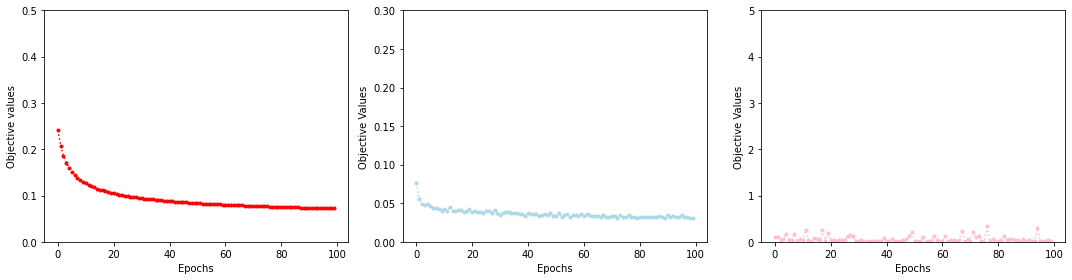

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Plot the first function on the first subplot
axes[1].plot(sgd_obj, label='Stochastic Gradient Descent', linestyle = 'dotted', marker='.' ,color = 'lightblue')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Objective Values')
axes[1].set_ylim(bottom=0, top=0.3)

# Plot the second function on the second subplot
axes[0].plot(gd_obj, label='Gradient Descent', linestyle = 'dotted',marker = '.', color='red')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Objective values')
axes[0].set_ylim(bottom=0, top=0.5)

axes[2].plot(obj_mbgd, label='Mini Batch Gradient Descent', linestyle = 'dotted',marker = '.',color = 'pink')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Objective Values')
axes[2].set_ylim(bottom=0, top=5)

# Adjust spacing between subplots and display the plot
plt.tight_layout()
plt.show()

# 5. Prediction
### Compare the training and testing accuracy for logistic regression and regularized logistic regression.

In [151]:
# Predict class label
# Inputs:
#     w: weights: d-by-1 matrix
#     X: data: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, x):
    f = numpy.dot(x, w)
    return numpy.sign(f)

In [156]:
# evaluate training error of logistic regression and regularized version
arr = {
  "Stochastic": w_sgd,
  "Stochastic_r": w_sgd_r ,
  "Minibatch": w_mbgd,
  "Minibatch_r": w_mbgd_r, 
  "normal" : w_gd,
  "normal_r" : w_gd_r
}

def train_error(arr, x_data, y_data):
    n = x_data.shape[0]
    for key ,val in arr.items():
        if(str(key[-1]) == 'r'):
            pred_r = predict(val, x_data)
            incorrect_r = numpy.sum(pred_r != y_data)
            error_rate = incorrect_r/n
            accuracy = 1-error_rate
            print("Error rate of Regularized Logistic Regression for",key[:-2],"Gradient Descent:",round(error_rate, 2))
            print("Accuracy of Regularized Logistic Regression for",key[:-2],"Gradient Descent:",round(accuracy, 2),"\n")
        else:
            pred = predict(val, x_data)
            incorrect = numpy.sum(pred != y_data)
            error_rate = incorrect/n
            accuracy = 1-error_rate
            print("Error rate of Logistic Regression for",key,"Gradient Descent:",round(error_rate, 2))
            print("Accuracy of Logistic Regression for",key,"Gradient Descent:",round(accuracy, 2),"\n")

train_error(arr, x_train, y_train)

Error rate of Logistic Regression for Stochastic Gradient Descent: 0.01
Accuracy of Logistic Regression for Stochastic Gradient Descent: 0.99 

Error rate of Regularized Logistic Regression for Stochastic Gradient Descent: 0.02
Accuracy of Regularized Logistic Regression for Stochastic Gradient Descent: 0.98 

Error rate of Logistic Regression for Minibatch Gradient Descent: 0.02
Accuracy of Logistic Regression for Minibatch Gradient Descent: 0.98 

Error rate of Regularized Logistic Regression for Minibatch Gradient Descent: 0.02
Accuracy of Regularized Logistic Regression for Minibatch Gradient Descent: 0.98 

Error rate of Logistic Regression for normal Gradient Descent: 0.02
Accuracy of Logistic Regression for normal Gradient Descent: 0.98 

Error rate of Regularized Logistic Regression for normal Gradient Descent: 0.02
Accuracy of Regularized Logistic Regression for normal Gradient Descent: 0.98 



In [157]:
# evaluate testing error of logistic regression and regularized version
y_test = numpy.array(y_test, dtype=numpy.float32).reshape(-1,1)
def train_error(arr, x_data, y_data):
    n = x_data.shape[0]
    for key ,val in arr.items():
        if(str(key[-1]) == 'r'):
            pred_r = predict(val, x_data)
            incorrect_r = numpy.sum(pred_r != y_data)
            error_rate = incorrect_r/n
            accuracy = 1-error_rate
            print("Error rate of Regularized Logistic Regression for",key[:-2],"Gradient Descent:",round(error_rate, 2))
            print("Accuracy of Regularized Logistic Regression for",key[:-2],"Gradient Descent:",round(accuracy, 2),"\n")
        else:
            pred = predict(val, x_data)
            incorrect = numpy.sum(pred != y_data)
            error_rate = incorrect/n
            accuracy = 1-error_rate
            print("Error rate of Logistic Regression for",key,"Gradient Descent:",round(error_rate, 2))
            print("Accuracy of Logistic Regression for",key,"Gradient Descent:",round(accuracy, 2),"\n")

train_error(arr, x_test, y_test)

Error rate of Logistic Regression for Stochastic Gradient Descent: 0.04
Accuracy of Logistic Regression for Stochastic Gradient Descent: 0.96 

Error rate of Regularized Logistic Regression for Stochastic Gradient Descent: 0.02
Accuracy of Regularized Logistic Regression for Stochastic Gradient Descent: 0.98 

Error rate of Logistic Regression for Minibatch Gradient Descent: 0.02
Accuracy of Logistic Regression for Minibatch Gradient Descent: 0.98 

Error rate of Regularized Logistic Regression for Minibatch Gradient Descent: 0.02
Accuracy of Regularized Logistic Regression for Minibatch Gradient Descent: 0.98 

Error rate of Logistic Regression for normal Gradient Descent: 0.02
Accuracy of Logistic Regression for normal Gradient Descent: 0.98 

Error rate of Regularized Logistic Regression for normal Gradient Descent: 0.02
Accuracy of Regularized Logistic Regression for normal Gradient Descent: 0.98 



# 6. Parameters tuning

In [161]:
from functools import reduce

# Define a function that performs the training and evaluation on a single fold
def cross_val_kfold(i,X_parts,y_parts, lam, lr):    
    x_test = X_parts[i]
    y_test = y_parts[i]
    # Set the remaining parts as the training data
    x_train = numpy.concatenate(X_parts[:i] + X_parts[i+1:])
    y_train = numpy.concatenate(y_parts[:i] + y_parts[i+1:])
    d = x_train.shape[1]
    w = numpy.zeros((d,1))

    #change the name of function if you need mini batch write 'mbgd' and for stochastic 'sgd'
    w_, obj_ = mbgd(x_train, y_train, lam, lr, w)     
    # Make predictions on the test set and compute the error rate and accuracy
    pred = predict(w_, x_test)
    incorrect_r = numpy.sum(pred != y_test)
    error_rate = incorrect_r / n
    accuracy = 1 - error_rate
    return (error_rate, accuracy)

# Define the number of folds 
k = 20
avg_rate, avg_acc = 0, 0
X = data1[:,1:32]
y = (data1[:,0]).reshape(-1,1)
X_parts = numpy.array_split(X, k)
y_parts = numpy.array_split(y, k)
# Use map and filter to apply the train_eval_fold function to each fold
output = map(lambda i: cross_val_kfold(i,X_parts,y_parts, 0.01, 0.1), range(k))
# Use reduce to compute the running sum of error rates and accuracies
avg_error_rate, avg_accuracy = reduce(lambda acc, res: (acc[0] + res[0], acc[1] + res[1]), output, (0, 0))
# Compute the average error rate and accuracy over all folds
avg_error_rate /= k
avg_accuracy /= k
print("Averaged test errors(validation error)",round(avg_error_rate,2))
print("Average test accuracy(validation error)",round(avg_accuracy,2))

<ipython-input-72-b019f2a65a89>:17: RuntimeWarning: overflow encountered in exp
  exp_term = (1 + numpy.exp(-val1)).astype(float)
<ipython-input-72-b019f2a65a89>:24: RuntimeWarning: overflow encountered in exp
  exp_term = (1 + numpy.exp(val1)).astype(float)


Averaged test errors(validation error) 0.01
Average test accuracy(validation error) 0.99


The above, **Tuning parameter** includes a function which consists logic for cross **validation kfold** log where I have divided x and y training amd testing set after fetching split from the actual data. After that, I have called **all three gradient functions** to obtain **updated weights**. This weights helps to **predict** the **validation set**  **error rate and accuray** per functions, which is then **averaged** for obtaining **validation error**. However, This function takes **longer time to compute** if loops are used. Hence, to avoid that issue, I have used optimized way by inculcating **map and reduce** concepts. I reduced time complexity by 4 times as before (while using normal for loop) it took 40.06 mins (more than half an hour)to compute the acccuracy and error rate, but now it takes only in 10 to 15 secs. 